## Imports

In [21]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
import sys
sys.path.append('../../Models')
from models import LSTMPredictor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pymongo import MongoClient
from dotenv import load_dotenv
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

load_dotenv()
cluster_uri = os.environ.get("MONGODB_URI")
client = MongoClient(cluster_uri)
db = client["MSCI446_DB"]


## Functions

In [22]:
def create_sequences(features, target, sequence_length):
    sequences = []
    target_sequences = []
    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i+sequence_length])
        target_sequences.append(target[i+1:i+1+sequence_length])
   
    sequences = np.array(sequences, dtype=np.float32)
    target_sequences = np.array(target_sequences, dtype=np.float32)
    
    return torch.from_numpy(sequences), torch.from_numpy(target_sequences)


def kfold_validation(X, y, n_hidden_options, lr_options, drop_out_options, num_epochs, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_score = float('inf')
    best_params = {}

    for n_hidden in n_hidden_options:
        for lr in lr_options:
            for dropout_rate in drop_out_options:
                fold_scores = []
                for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                    print(f"Running Fold {fold + 1}/{k_folds}, n_hidden: {n_hidden}, lr: {lr}, dropout: {dropout_rate}")
            
                    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
                    
                    train_dataset = TensorDataset(X_train_fold, y_train_fold)
                    val_dataset = TensorDataset(X_val_fold, y_val_fold)
                    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
                    
                    model = LSTMPredictor(input_features=X_train_fold.shape[2], n_hidden=n_hidden, output_features=1, dropout_rate=dropout_rate).to(device)
                    criterion = nn.MSELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    
                    train_model(model, train_loader, criterion, optimizer, num_epochs, device)
                    
                    _, val_predictions, val_actuals = test_model(model, val_loader, criterion, device)
                    val_mae = mean_absolute_error(val_actuals.cpu().numpy(), val_predictions.cpu().numpy())
                    val_mse = mean_squared_error(val_actuals.cpu().numpy(), val_predictions.cpu().numpy())
                    val_r2 = r2_score(val_actuals.cpu().numpy(), val_predictions.cpu().numpy())
                    
                    fold_scores.append((val_mae, val_mse, val_r2))
   
                avg_mae = np.mean([score[0] for score in fold_scores])
                avg_mse = np.mean([score[1] for score in fold_scores])
                avg_r2 = np.mean([score[2] for score in fold_scores])
                print(f"Average MAE: {avg_mae:.4f}, Average MSE: {avg_mse:.4f}, Average R²: {avg_r2:.4f} for n_hidden: {n_hidden}, lr: {lr}, dropout: {dropout_rate}")
                
                if avg_mae < best_score:
                    best_score = avg_mae
                    best_params = {'n_hidden': n_hidden, 'lr': lr, 'dropout_rate': dropout_rate}

    return best_params, best_score

def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0  
        for seq, targets in train_loader:
            seq, targets = seq.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(seq).to(device)
            output = output.unsqueeze(-1)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)  
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')
    return train_losses

def test_model(model, test_loader, criterion, device, future=0):
    model.eval()
    predictions = []
    actuals = []
    test_losses = []
    total_loss = 0
    index = 0
    with torch.no_grad():
        for seq, targets in test_loader:
            seq, targets = seq.to(device), targets.to(device)
            output = model(seq, future=future).to(device)
            if future > 0:
               
                extended_targets = torch.cat([targets, torch.zeros(targets.size(0), future, 1, device=device)], dim=1)
            else:
                extended_targets = targets
            
           
            output = output.unsqueeze(-1)
            loss = criterion(output, extended_targets)
            total_loss += loss.item()
            test_losses.append(loss.item())
            predictions.append(output.cpu())
            actuals.append(extended_targets.cpu())
            index += 1
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss}')
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)
    return test_losses, predictions, actuals

def test_model_and_calc_metrics(model, test_loader, criterion, device, future=0):
    model.eval()
    predictions = []
    actuals = []
    test_losses = []
    total_loss = 0
    sequence_metrics = []  

    with torch.no_grad():
        for seq, targets in test_loader:
            seq, targets = seq.to(device), targets.to(device)
            output = model(seq, future=future).to(device)
            
            if future > 0:
                extended_targets = torch.cat([targets, torch.zeros(targets.size(0), future, 1, device=device)], dim=1)
            else:
                extended_targets = targets
            
            output = output.unsqueeze(-1)
            loss = criterion(output, extended_targets)
            total_loss += loss.item()
            test_losses.append(loss.item())

            predictions.append(output.cpu())
            actuals.append(extended_targets.cpu())

            for pred, actual in zip(output, extended_targets):
                pred_np = pred.cpu().squeeze(-1).numpy()
                actual_np = actual.cpu().squeeze(-1).numpy()
                mae = mean_absolute_error(actual_np, pred_np)
                mse = mean_squared_error(actual_np, pred_np)
                r2 = r2_score(actual_np, pred_np)
                sequence_metrics.append((mae, mse, r2))

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss}')
    
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return sequence_metrics, test_losses, predictions, actuals


def predict_future(model, input_sequence, device, future_steps=1):
    model.eval()  
    predictions = []

    with torch.no_grad(): 
        for seq, targets in input_sequence:
            seq, targets = seq.to(device), targets.to(device)
            pred = model(seq, future=future_steps)
            
            predictions.append(pred)
        
      
        predictions = torch.cat(predictions, dim=0)

    return predictions



def print_metrics(actuals, predictions):
    r2 = r2_score(actuals.squeeze(-1).numpy(), predictions.squeeze(-1).numpy())
    mae = mean_absolute_error(actuals.squeeze(-1).numpy(),predictions.squeeze(-1).numpy())
    print(f'R² Score: {r2}')
    print(f'Mean Absolute Error: {mae}')

def print_sequence_metrics(sequence_metrics):
    for i, (mae, mse, r2) in enumerate(sequence_metrics, 1):
        print(f"Sequence {i}: MAE = {mae:.3f}, MSE = {mse:.3f}, R² = {r2:.3f}")

def calculate_and_print_average_metrics(sequence_metrics):
    total_mae, total_mse, total_r2 = 0, 0, 0
    for mae, mse, r2 in sequence_metrics:
        if (r2 < 0):
            r2 = 0
        total_mae += mae
        total_mse += mse
        total_r2 += r2

    
    avg_mae = total_mae / len(sequence_metrics)
    avg_mse = total_mse / len(sequence_metrics)
    avg_r2 = total_r2 / len(sequence_metrics)

    
    print(f"Average MAE = {avg_mae:.3f}")
    print(f"Average MSE = {avg_mse:.3f}")
    print(f"Average R² = {avg_r2:.3f}")

def print_best_sequence_metrics(sequence_metrics):
   
    best_mae = float('inf')
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_mae_seq = best_mse_seq = best_r2_seq = 0

    for i, (mae, mse, r2) in enumerate(sequence_metrics, start=1):
        if mae < best_mae:
            best_mae = mae
            best_mae_seq = i
        if mse < best_mse:
            best_mse = mse
            best_mse_seq = i
        if r2 > best_r2:
            best_r2 = r2
            best_r2_seq = i

    print(f"Best MAE: {best_mae:.3f} (Sequence {best_mae_seq})")
    print(f"Best MSE: {best_mse:.3f} (Sequence {best_mse_seq})")
    print(f"Best R²: {best_r2:.3f} (Sequence {best_r2_seq})")
   



def plot_predictions(predictions, actuals, num_sequences=5):
    for i in range(min(num_sequences, predictions.size(0))):
        df = pd.DataFrame(data={
            'Time Step': list(range(predictions.size(1))) * 2,
            'Value': torch.cat((actuals[i, :, 0], predictions[i, :, 0]), dim=0).numpy(),
            'Type': ['Actual'] * predictions.size(1) + ['Predicted'] * predictions.size(1)
        })

        plt.figure(figsize=(10, 4))
        plt.title(f'Sequence {i+1}')
        sns.lineplot(x='Time Step', y='Value', hue='Type', style='Type', markers=True, dashes=False, data=df)
        plt.legend(title='Type')
        plt.show()
    
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()

def plot_training_loss(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

def plot_individual_sequence_predictions(predictions, actuals, num_sequences=5):
    num_sequences = min(num_sequences, predictions.size(0))
    
    for i in range(num_sequences):
       
        actual_sequence = actuals[i, :, 0].numpy()
        predicted_sequence = predictions[i, :, 0].numpy()
        
        df = pd.DataFrame({
            'Time Step': np.arange(len(actual_sequence) + len(predicted_sequence)),
            'Value': np.concatenate((actual_sequence, predicted_sequence)),
            'Type': ['Actual'] * len(actual_sequence) + ['Predicted'] * len(predicted_sequence)
        })
        
        plt.figure(figsize=(10, 4))
        sns.lineplot(data=df, x='Time Step', y='Value', hue='Type', style='Type', markers=True, dashes=False)
        plt.title(f'Sequence {i+1} Predictions vs Actuals')
        plt.legend()
        plt.show()


## Loading Data

In [23]:
data = pd.read_csv('../Data/Final_table.csv')


# collection_merged = db["Merged"]
# data = pd.DataFrame(list(collection_merged.find()))
# data = data.drop(columns=['_id'])
data.head()


,datetime_beginning_ept,MIDATL_solar,OTHER_solar,RFC_solar,RTO_solar,SOUTH_solar,WEST_solar,MIDATL_wind,OTHER_wind,RFC_wind,...,DOM_forecast,DUQ_forecast,EKPC_forecast,MIDATL_forecast,RTO_forecast,DPL_historical_da,forecast_gen_outage_mw_rto,forecast_gen_outage_mw_west,forecast_gen_outage_mw_other,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,19/02/2022 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,543.833,0.0,7749.579,...,13124.200000,1428.2,1825.200000,29872.800000,90802.0,38.95,3216.836735,267.714286,2949.122449,4.61
1,19/02/2022 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,631.555,0.0,7669.941,...,13098.200000,1399.4,1818.400000,29506.400000,89577.4,36.43,3216.836735,267.714286,2949.122449,4.61
2,19/02/2022 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,736.464,0.0,7726.962,...,13255.800000,1381.4,1824.600000,29435.800000,89291.6,36.36,3216.836735,267.714286,2949.122449,4.61
3,19/02/2022 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,783.231,0.0,7896.692,...,13455.400000,1375.4,1831.400000,29589.800000,89587.8,36.59,3216.836735,267.714286,2949.122449,4.61
4,19/02/2022 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,860.240,0.0,8150.219,...,13840.333333,1384.5,1882.333333,30146.166667,91159.0,38.60,3216.836735,267.714286,2949.122449,4.61


## Scaling Features and Target Value

In [24]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['datetime_beginning_ept', 'DPL_historical_da']))
scaled_target = scaler.fit_transform(data[['DPL_historical_da']])

## Creating Sequences

In [25]:
X, y = create_sequences(scaled_features, data[['DPL_historical_da']], sequence_length=72)

## Splitting into Train and Test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

## Feature Selection

In [27]:
n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape((n_samples * n_timesteps, n_features))
y_train_reshaped = y_train.reshape((n_samples * n_timesteps,))


model_fr = SelectKBest(score_func=f_regression, k=5)

data_new_fr = model_fr.fit(X_train_reshaped, y_train_reshaped)

#print("f_regression: ", data_new_fr.get_feature_names_out())

feature_names = data.drop(columns=['datetime_beginning_ept', 'DPL_historical_da']).columns.tolist()

selected_features_mask = model_fr.get_support()
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features_mask[i]]
print("Selected features:", selected_feature_names)

Selected features: ['APS_forecast', 'DOM_forecast', 'MIDATL_forecast', 'RTO_forecast', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)']


In [28]:
X_train_best = model_fr.transform(X_train_reshaped)  
X_test_best = model_fr.transform(X_test.reshape((X_test.shape[0] * X_test.shape[1], X_test.shape[2])))

X_train_best = X_train_best.reshape((X_train.shape[0], X_train.shape[1], -1))
X_test_best = X_test_best.reshape((X_test.shape[0], X_test.shape[1], -1))

## Converting to Valid Pytorch Input

In [29]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [30]:
train_dataset_best = TensorDataset(torch.from_numpy(X_train_best), y_train)
train_loader_best = DataLoader(train_dataset_best, batch_size=64, shuffle=False)

test_dataset_best = TensorDataset(torch.from_numpy(X_test_best), y_test)
test_loader_best = DataLoader(test_dataset_best, batch_size=64, shuffle=False)

## K-fold-cross-validation

In [31]:
# n_hidden_options = [16, 32, 50, 64, 128]
# lr_options = [0.1, 0.01, 0.05, 0.001, 0.0001]
# drop_out_options = [0.1, 0.2, 0.3, 0.4, 0.5]
# num_epochs = 50

# best_params, best_score = kfold_validation(X, y, n_hidden_options, lr_options, drop_out_options, num_epochs)

# print(f"Best Hyperparameters: {best_params}")
# print(f"Best Validation Score: {best_score}")


## **Note**

### I tried to do 5 K-fold cross validation but due to time constraints it would take too long to run, so the code has been commented

## Training Model

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_best = LSTMPredictor(input_features=X_train_best.shape[2], n_hidden=best_params['n_hidden'], output_features=1, dropout_rate = best_params['dropout_rate']).to(device)
model_best = LSTMPredictor(input_features=X_train_best.shape[2], n_hidden= 51, output_features=1).to(device)


criterion = nn.MSELoss()
# optimizer_adam = optim.Adam(model_best.parameters(), lr=best_params['lr_options'])
optimizer_adam = optim.Adam(model_best.parameters(), lr=0.001)
num_epochs = 75
train_losses_best = train_model(model_best, train_loader_best, criterion, optimizer_adam, num_epochs, device)

Epoch 1, Average Loss: 5113.5489929376645
Epoch 2, Average Loss: 4364.427705072802
Epoch 3, Average Loss: 3868.350024440677
Epoch 4, Average Loss: 3526.909323980642
Epoch 5, Average Loss: 3296.3309011769848
Epoch 6, Average Loss: 3143.8412900791614
Epoch 7, Average Loss: 3045.037588607433
Epoch 8, Average Loss: 2982.1989468419274
Epoch 9, Average Loss: 2942.8529838384584
Epoch 10, Average Loss: 2918.5058016400003
Epoch 11, Average Loss: 2903.550565480077
Epoch 12, Average Loss: 2894.3872020277868
Epoch 13, Average Loss: 2888.7572288158326
Epoch 14, Average Loss: 2885.2666665720385
Epoch 15, Average Loss: 2883.06087893109
Epoch 16, Average Loss: 2881.6026679105535
Epoch 17, Average Loss: 2880.54174692908
Epoch 18, Average Loss: 2879.7133247375486
Epoch 19, Average Loss: 2867.330849864871
Epoch 20, Average Loss: 2789.3117082196613
Epoch 21, Average Loss: 2679.0451709702957
Epoch 22, Average Loss: 2502.4342283204546
Epoch 23, Average Loss: 2395.648234478263
Epoch 24, Average Loss: 2315.37

## Plotting Train Loss

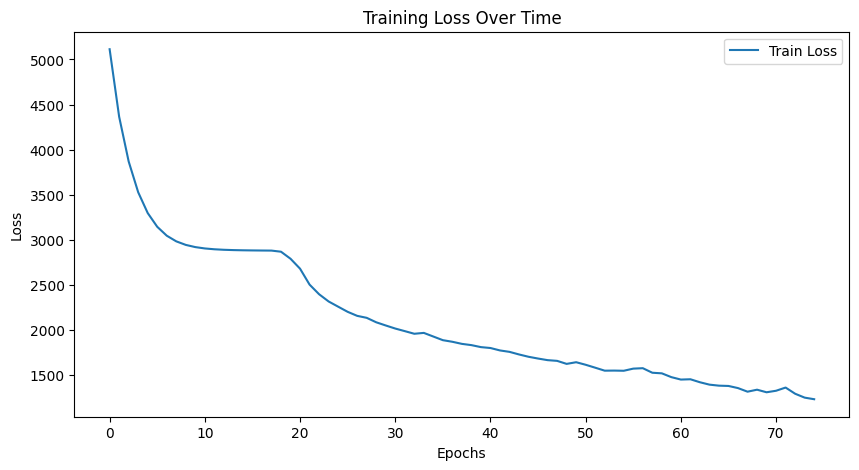

In [33]:
plot_training_loss(train_losses_best)

In [34]:
sequence_metrics, test_losses, predictions, actuals = test_model_and_calc_metrics(model_best, test_loader_best, criterion, device, future=0)

Test Loss: 1359.423547691769


## Metrics

### Treating the Data As Hourly

In [35]:
print_metrics(actuals, predictions)

R² Score: 0.03557435035859214
Mean Absolute Error: 18.298072814941406


### Treating the Data As Sequential Points

#### Sequential Metrics For Each Sequence 

In [36]:
print_sequence_metrics(sequence_metrics)

Sequence 1: MAE = 3.849, MSE = 21.004, R² = 0.320
Sequence 2: MAE = 3.929, MSE = 21.594, R² = 0.324
Sequence 3: MAE = 3.987, MSE = 22.300, R² = 0.324
Sequence 4: MAE = 4.142, MSE = 23.787, R² = 0.302
Sequence 5: MAE = 4.381, MSE = 25.651, R² = 0.273
Sequence 6: MAE = 4.527, MSE = 27.227, R² = 0.250
Sequence 7: MAE = 4.547, MSE = 27.591, R² = 0.237
Sequence 8: MAE = 4.611, MSE = 28.256, R² = 0.192
Sequence 9: MAE = 4.763, MSE = 29.993, R² = 0.105
Sequence 10: MAE = 4.941, MSE = 32.448, R² = -0.018
Sequence 11: MAE = 5.260, MSE = 36.269, R² = -0.147
Sequence 12: MAE = 5.501, MSE = 40.546, R² = -0.255
Sequence 13: MAE = 5.650, MSE = 44.337, R² = -0.342
Sequence 14: MAE = 5.743, MSE = 47.031, R² = -0.393
Sequence 15: MAE = 5.726, MSE = 47.208, R² = -0.369
Sequence 16: MAE = 5.756, MSE = 47.341, R² = -0.395
Sequence 17: MAE = 5.739, MSE = 46.671, R² = -0.435
Sequence 18: MAE = 5.735, MSE = 46.743, R² = -0.594
Sequence 19: MAE = 5.795, MSE = 48.527, R² = -1.095
Sequence 20: MAE = 5.822, MSE 

#### Average of All the Sequences

In [37]:
calculate_and_print_average_metrics(sequence_metrics)

Average MAE = 18.298
Average MSE = 1368.833
Average R² = 0.054


#### Best Metrics

In [38]:
print_best_sequence_metrics(sequence_metrics)

Best MAE: 2.278 (Sequence 3414)
Best MSE: 9.255 (Sequence 3215)
Best R²: 0.692 (Sequence 3139)


## Plotting Results

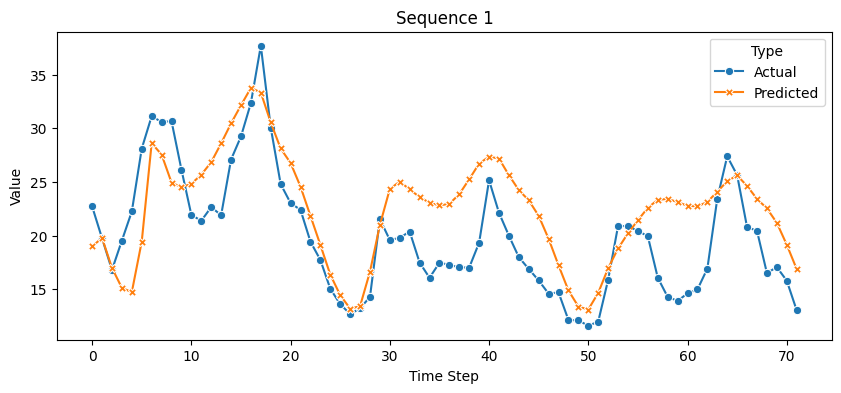

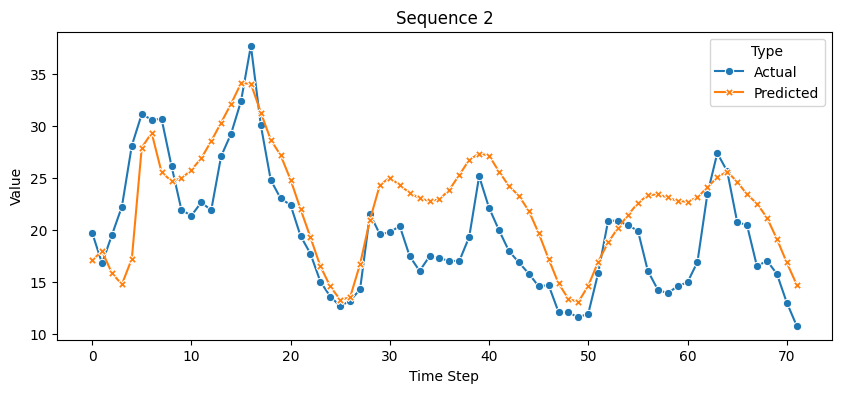

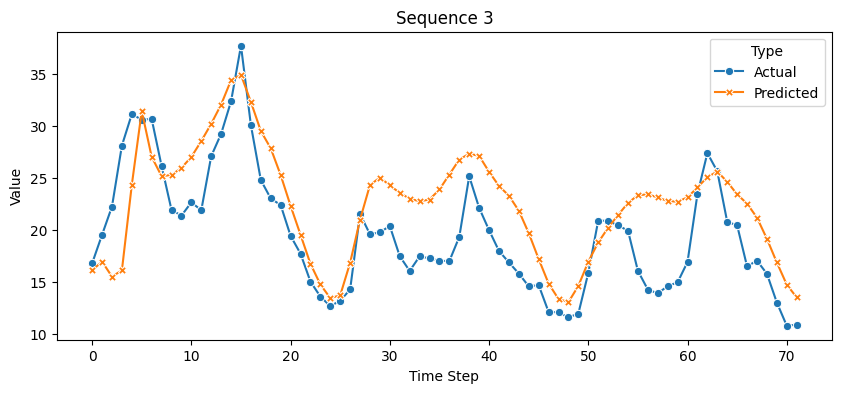

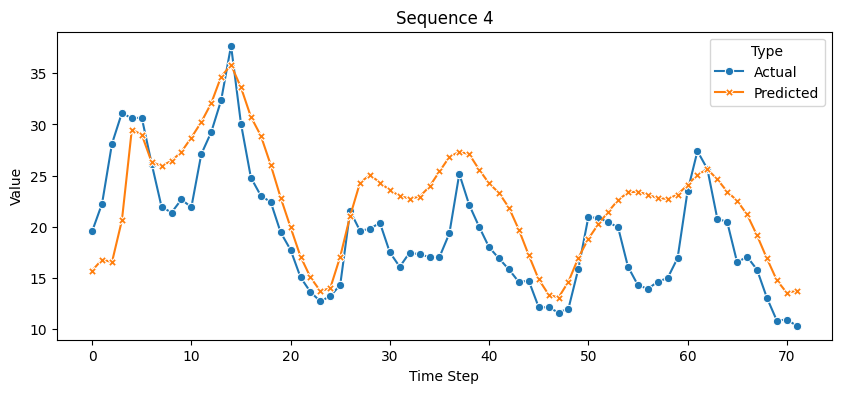

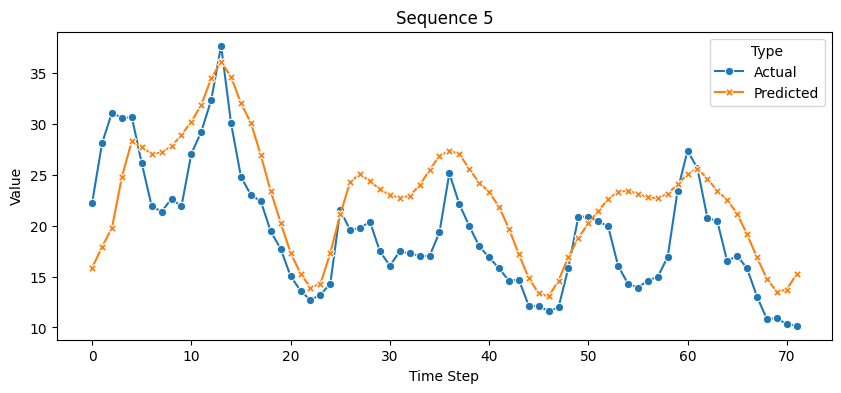

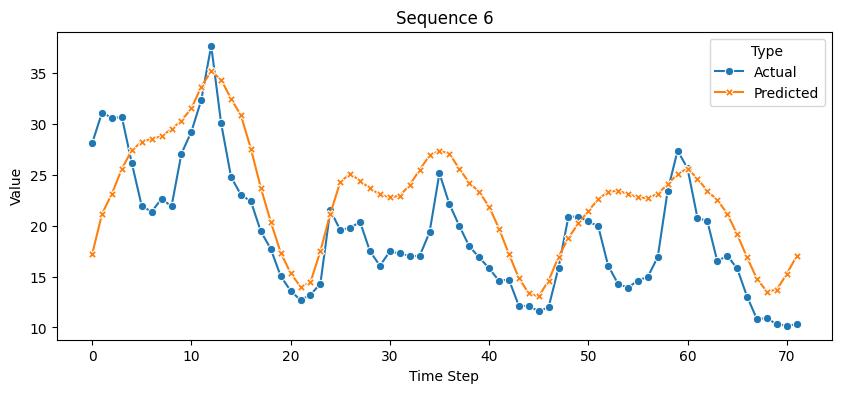

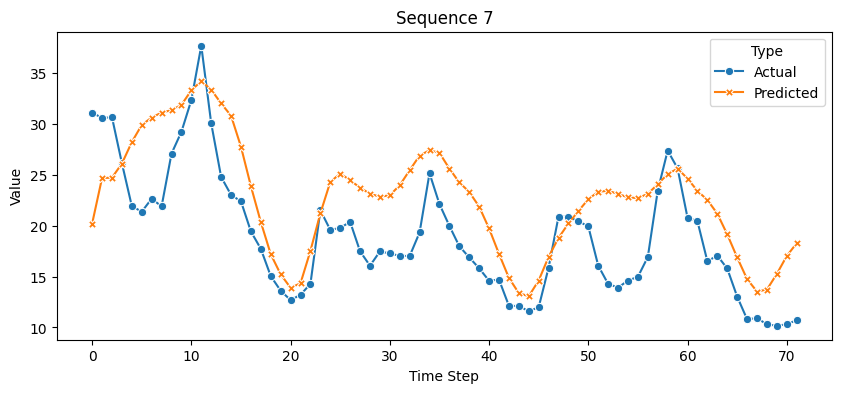

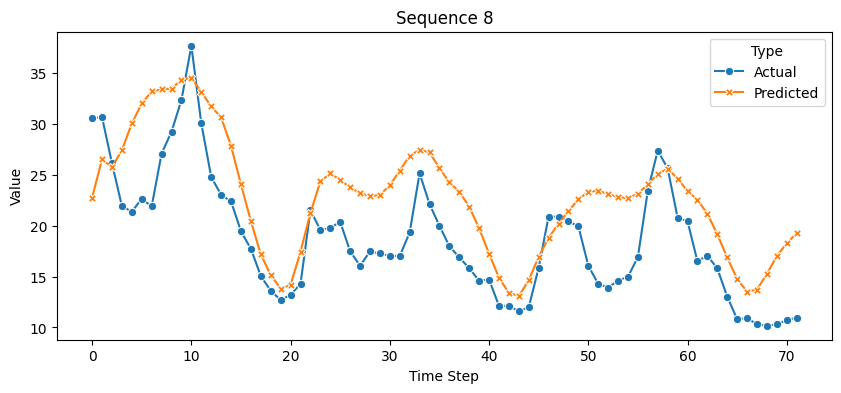

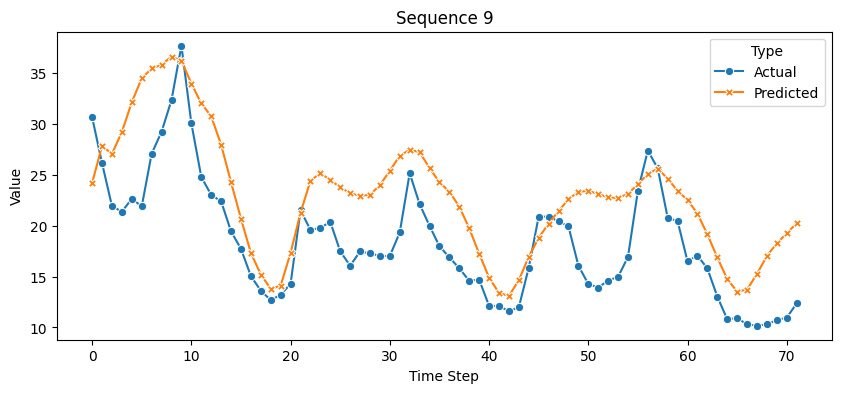

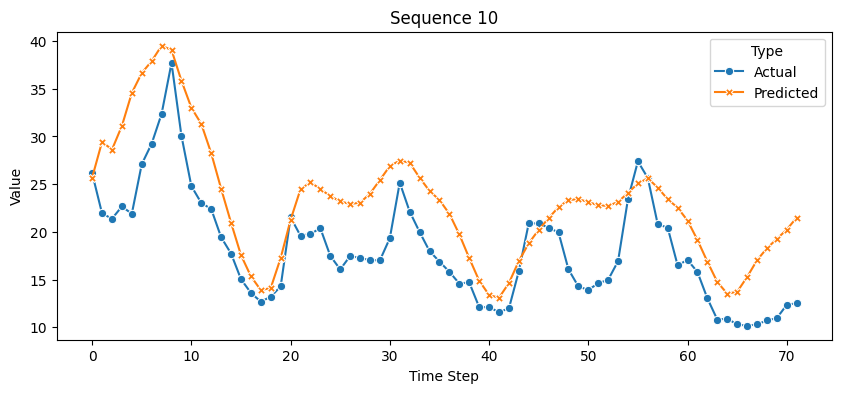

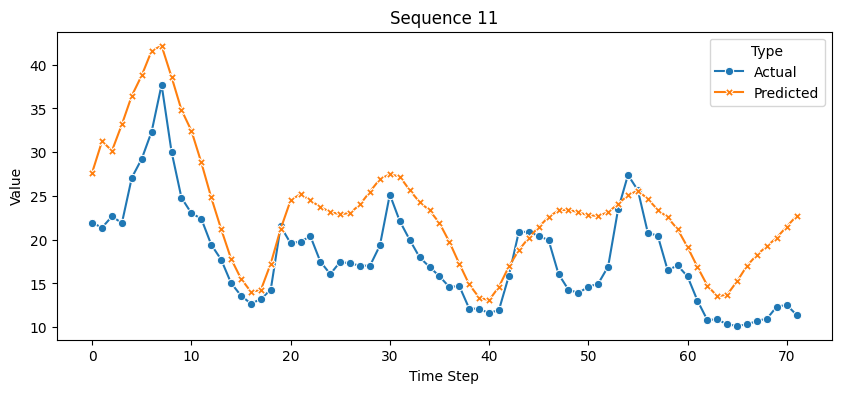

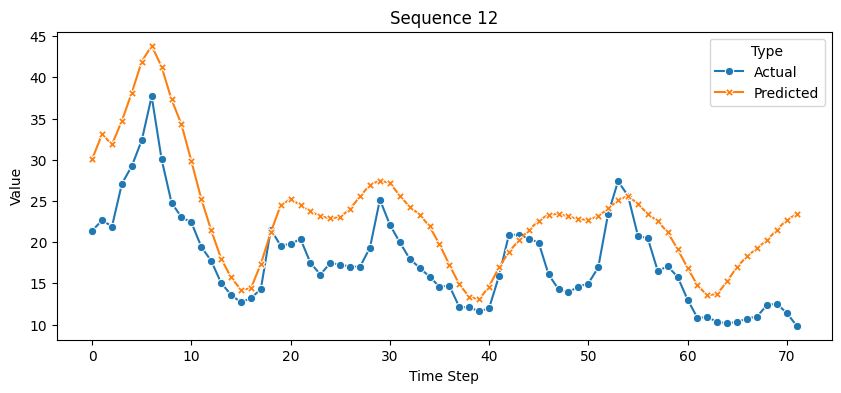

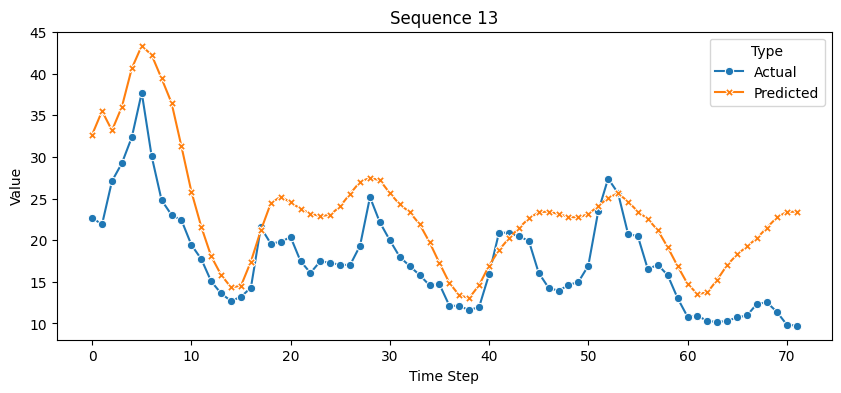

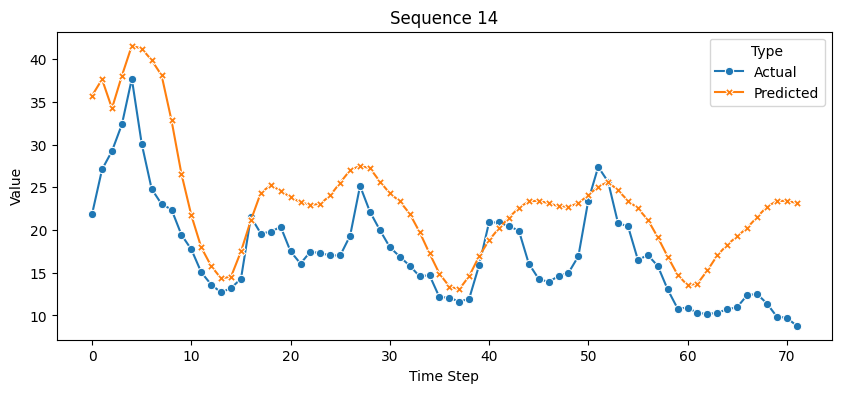

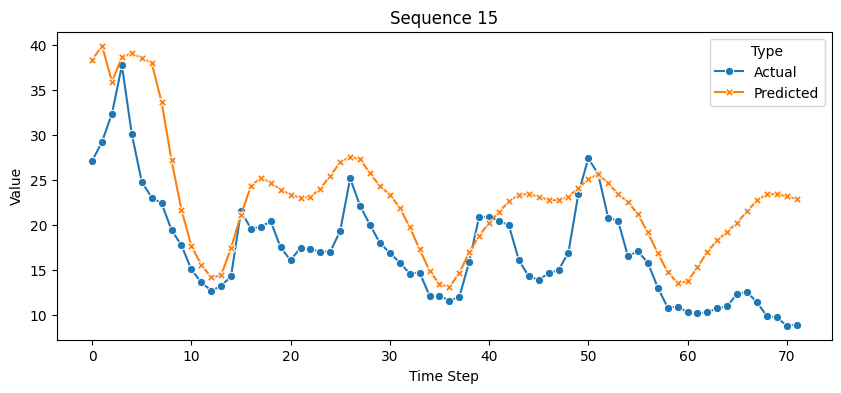

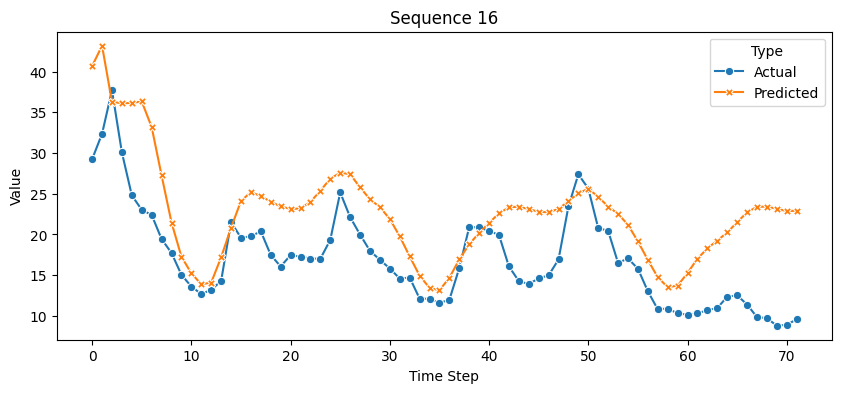

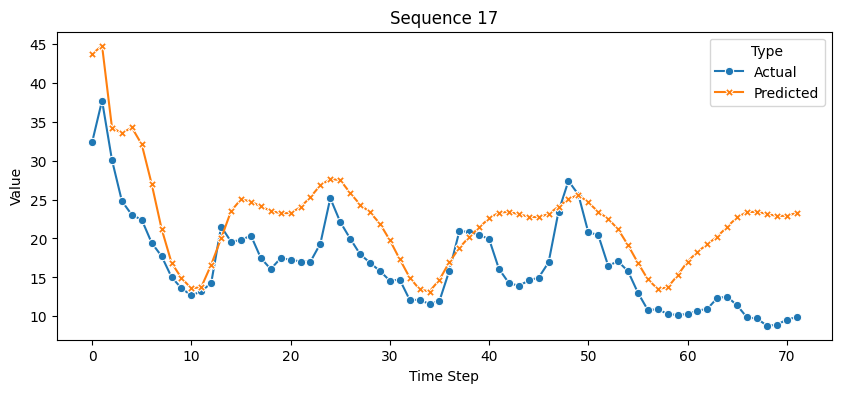

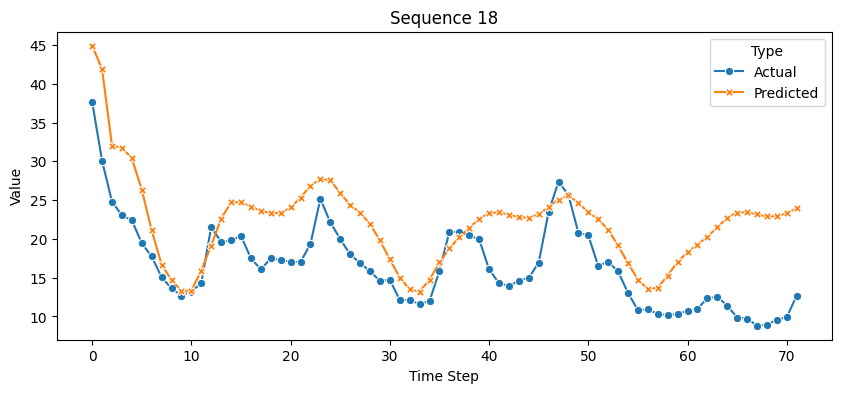

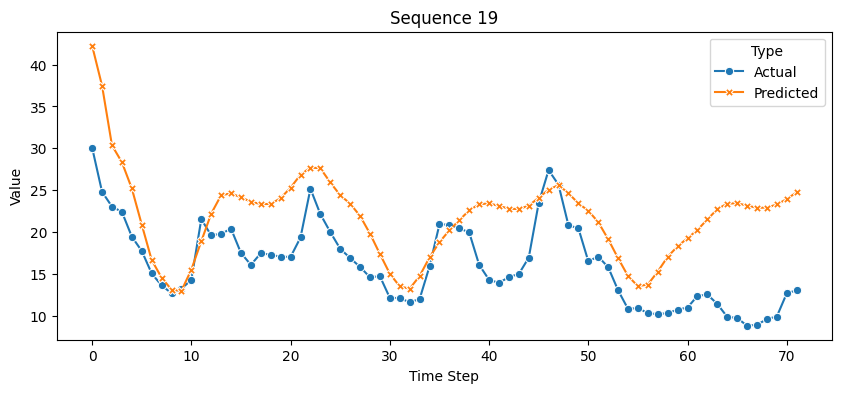

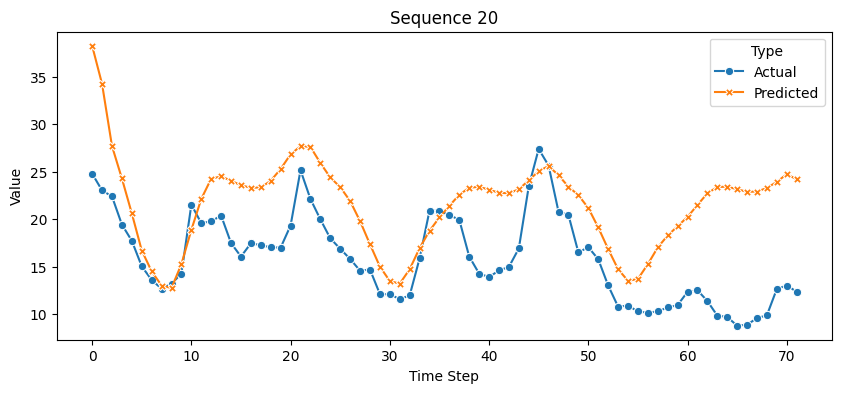

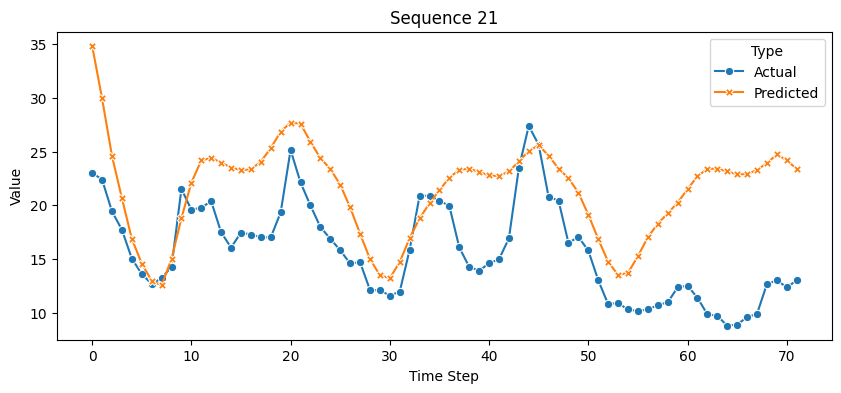

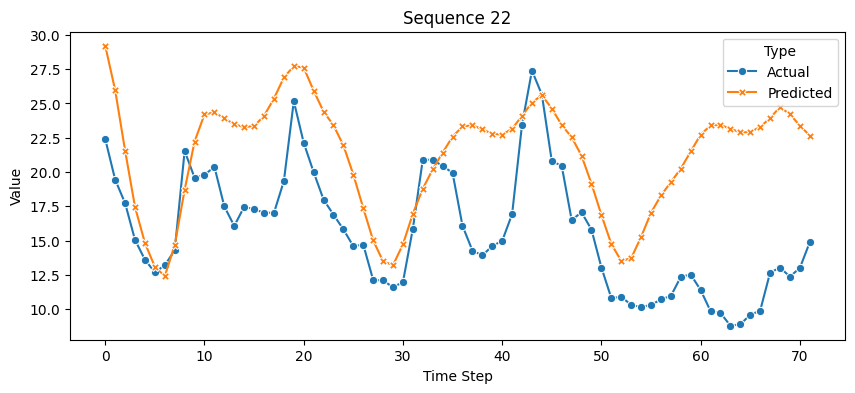

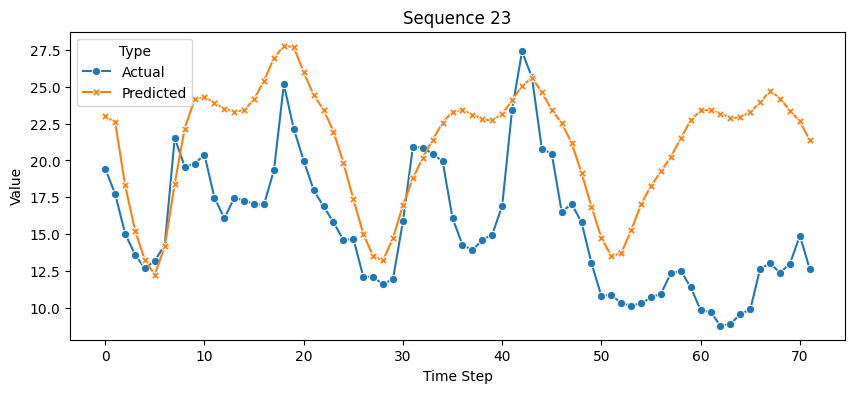

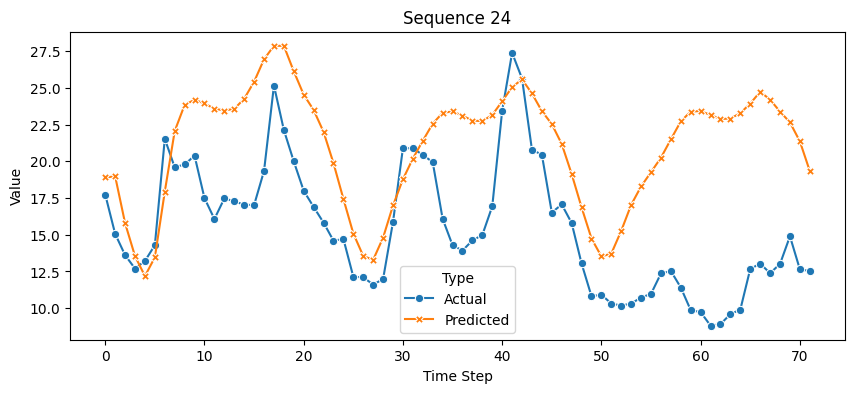

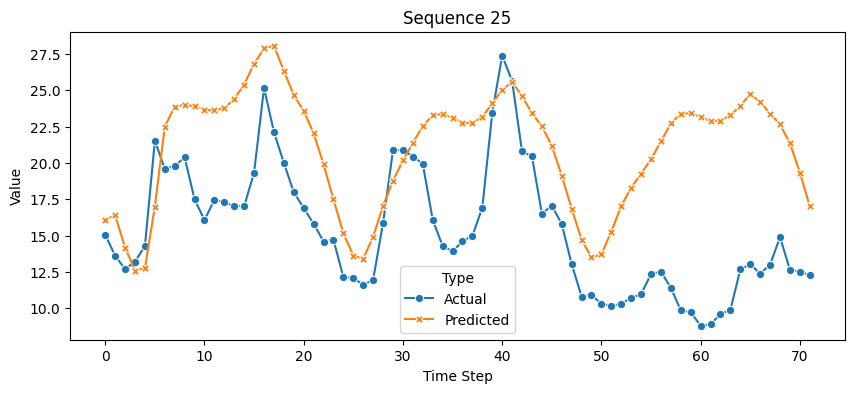

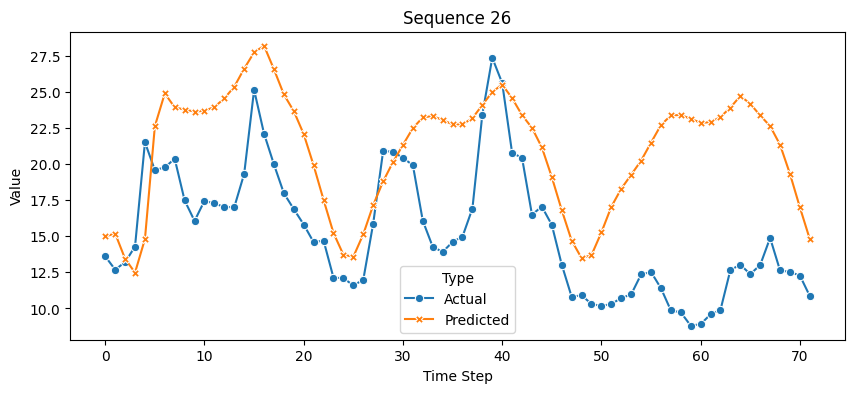

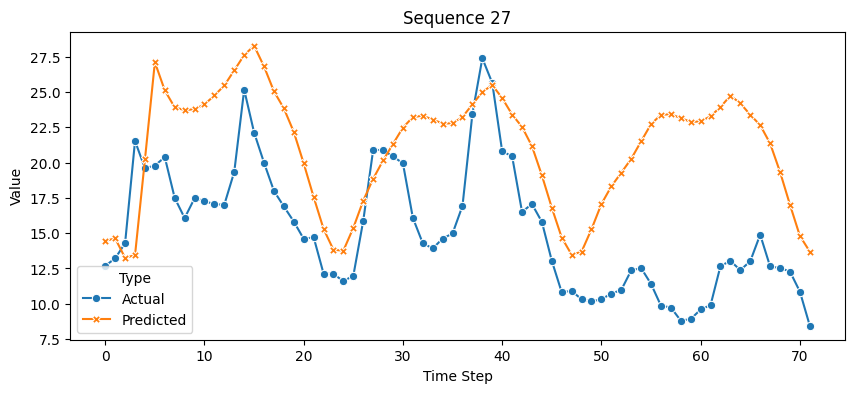

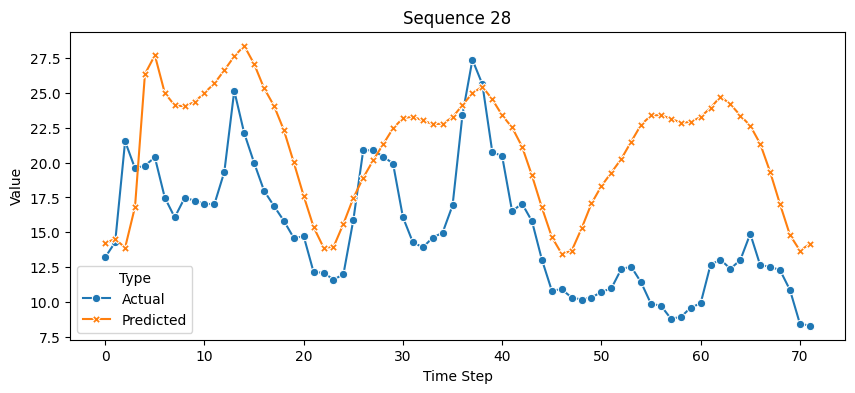

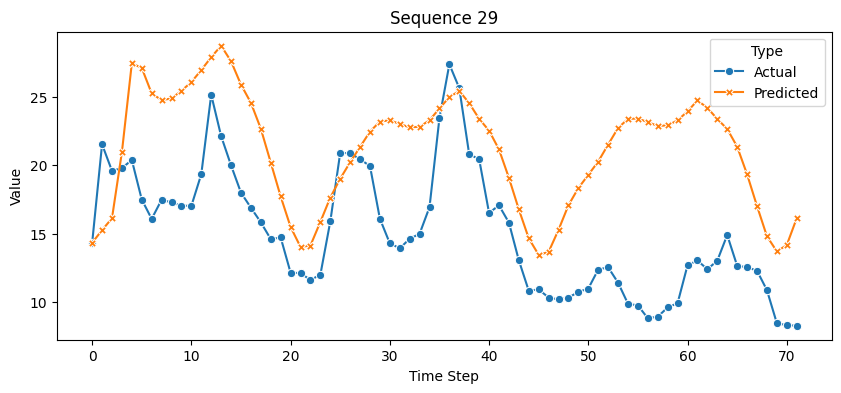

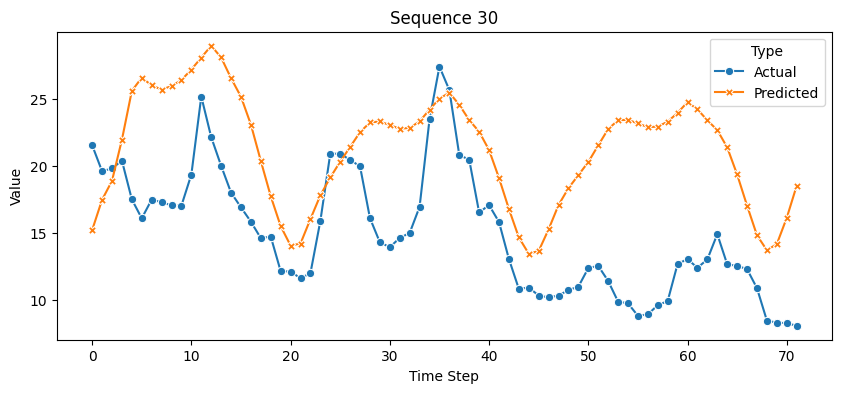

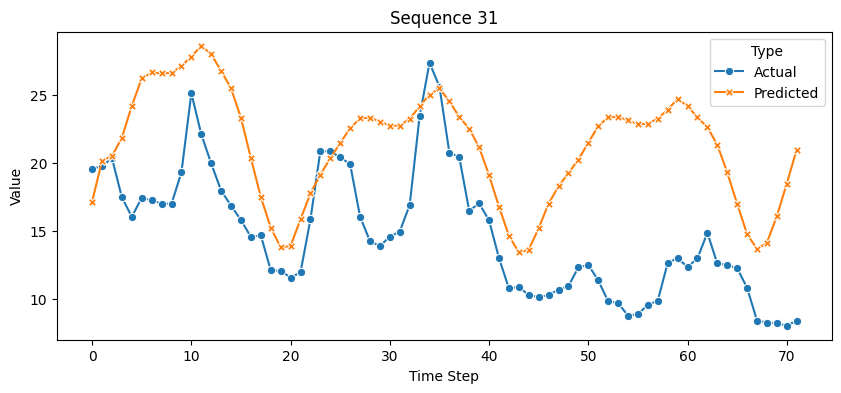

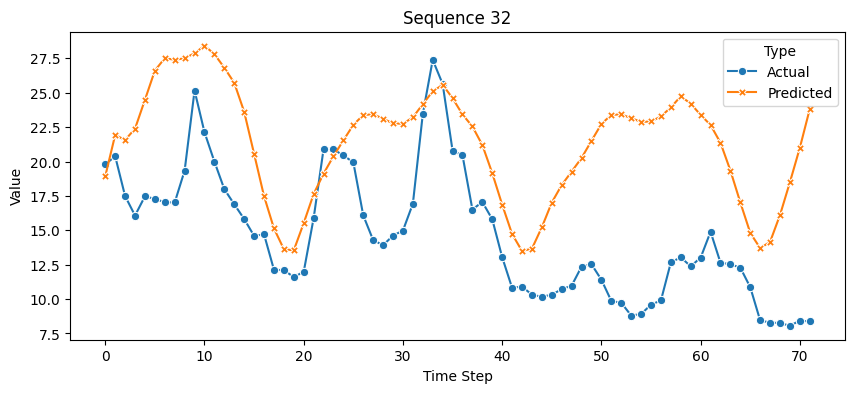

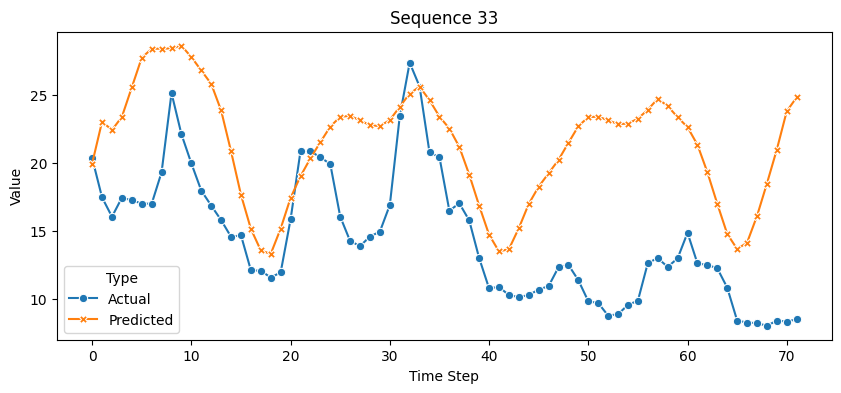

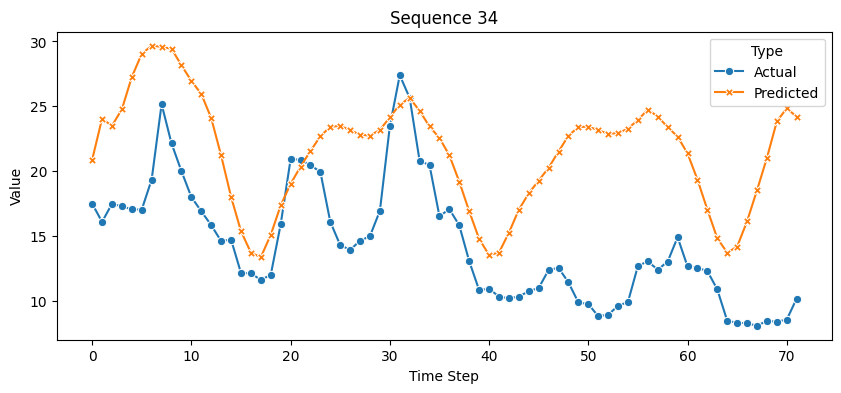

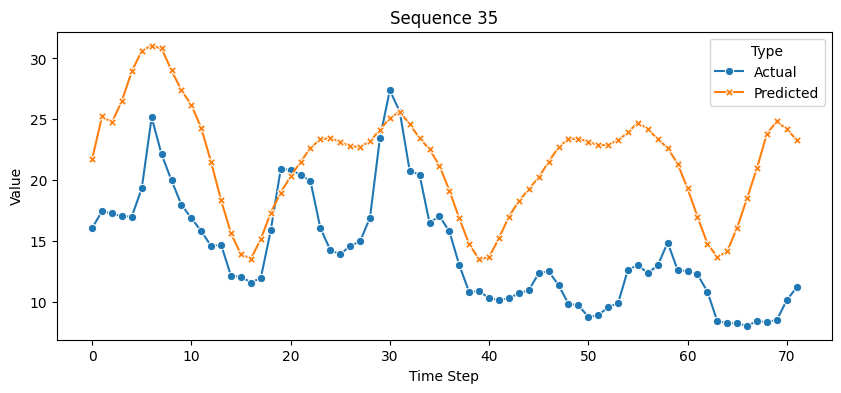

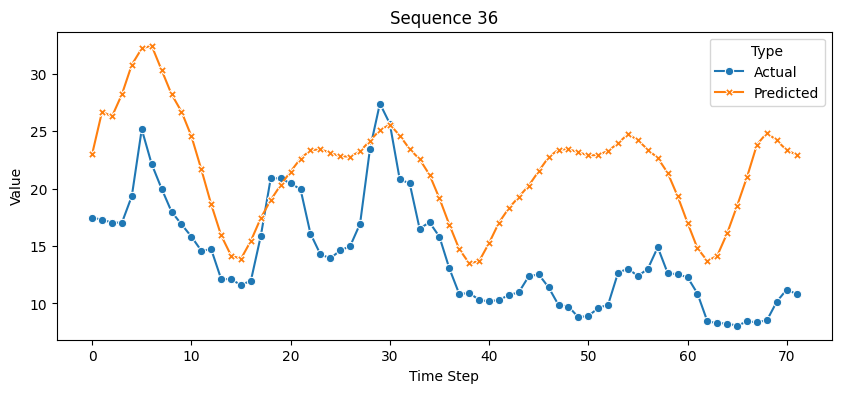

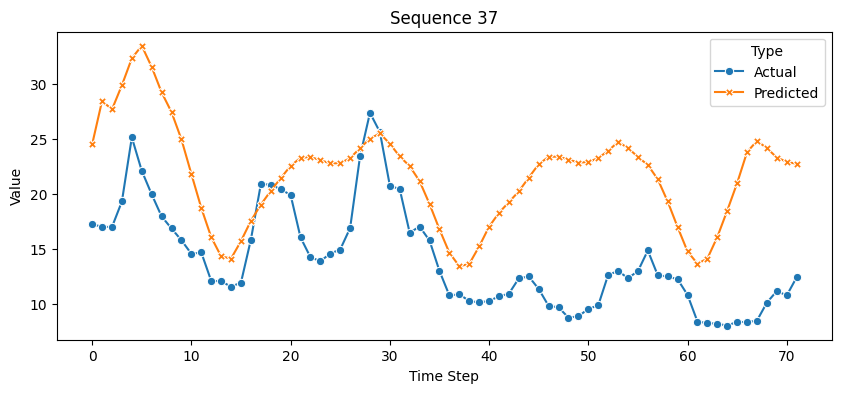

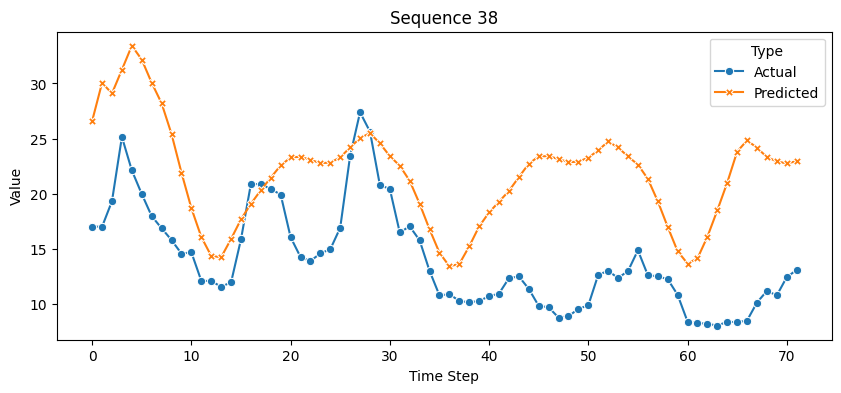

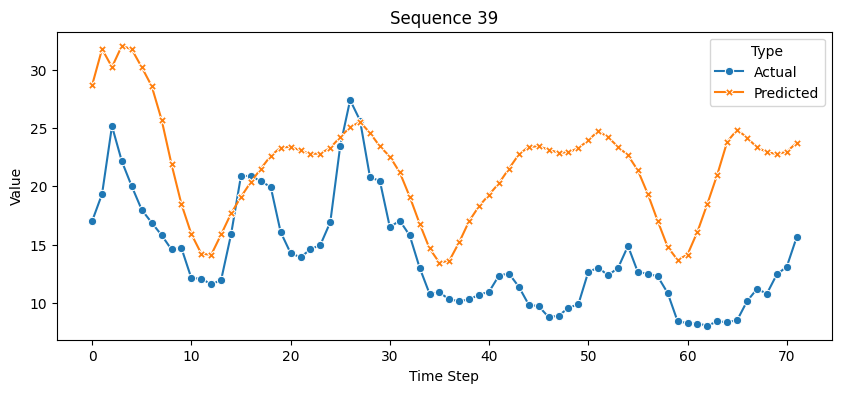

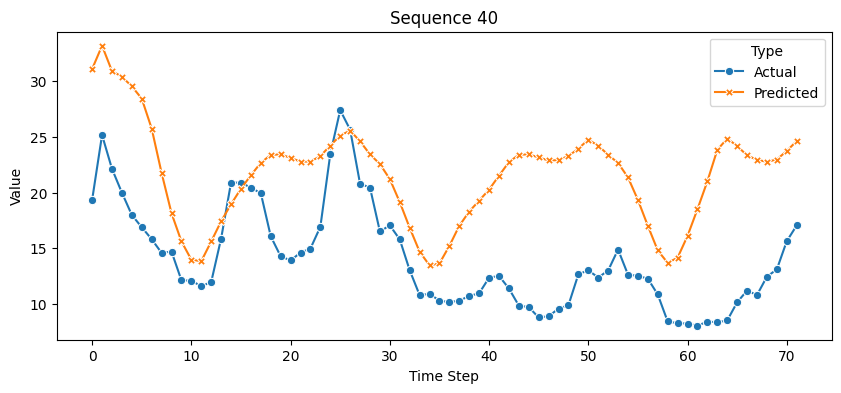

In [39]:
plot_predictions(predictions, actuals, num_sequences=40)

## Predicting Future Values

In [41]:
future_values = predict_future(model_best, test_loader_best, device, future_steps=10)
future_predictions = future_values[:, -10:]

future_predictions_2d = future_predictions.reshape(-1, 1)

# Inverse transform to get back to the original dollar values
unscaled_future_predictions = scaler.inverse_transform(future_predictions_2d)

# Reshape back to the original shape with future predictions
unscaled_future_predictions = unscaled_future_predictions.reshape(future_predictions.shape)

In [42]:
for i, future_values in enumerate(future_predictions):
    print(f"Future Values for Sequence {i+1}:")
    print(f"Unscaled: {future_values}")
    print("\n") 

Future Values for Sequence 1:
Unscaled: tensor([126.2553, 143.9260, 146.9844, 147.3929, 148.0392, 150.3714, 152.7333,
        153.3360, 153.4258, 153.4430])


Future Values for Sequence 2:
Unscaled: tensor([126.7487, 144.3034, 147.0239, 147.4500, 148.3508, 151.0155, 152.9606,
        153.3712, 153.4308, 153.4446])


Future Values for Sequence 3:
Unscaled: tensor([126.6684, 144.4464, 147.0433, 147.5398, 148.8045, 151.6563, 153.1298,
        153.3961, 153.4344, 153.4457])


Future Values for Sequence 4:
Unscaled: tensor([126.3227, 144.4392, 147.0419, 147.5723, 148.9580, 151.8216, 153.1667,
        153.4014, 153.4352, 153.4464])


Future Values for Sequence 5:
Unscaled: tensor([126.1043, 144.3539, 147.0201, 147.4930, 148.5870, 151.3827, 153.0631,
        153.3864, 153.4330, 153.4455])


Future Values for Sequence 6:
Unscaled: tensor([125.8514, 144.1407, 146.9876, 147.4032, 148.1052, 150.5276, 152.7952,
        153.3458, 153.4272, 153.4428])


Future Values for Sequence 7:
Unscaled: tensor

## **Note**

### Tried to protect a N number of future steps but was not able to get it working in time, created a work around but very inaccurate

## Saving Model

In [43]:
# torch.save(model_best.state_dict(), '../Models/model_LSTM.pth') # Save the model